# preprocessing

In [1]:
from kmer_feature_matrix_pipeline_funcs import *
from filtering_functions import *
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/Users/joesouber/OneDrive - University of Bristol/MSc Data Science/data science mini project/dsmp-2024-group-13/vdjdb_full.txt', sep='\t')
df = pd.DataFrame(df)

df_preprocessed = preprocess_data(df)
df_preprocessed_species = filter_by_species(df_preprocessed)
df_preprocessed_species_min_score = filter_by_minimum_score(df_preprocessed_species)
df_filtered_epitope = filter_by_length_range(df_preprocessed_species_min_score, 'antigen.epitope')
df_done = filter_by_mhc_class(df_preprocessed_species_min_score)
# Assuming 'df' is your original DataFrame
min_instances = 5 # Set the minimum number of instances required for inclusion
filtered_df = filter_by_epitope_instances(df_done, label_col='antigen.epitope', min_instances=min_instances)

print(f"Original DataFrame had {len(df_done)} rows.")
print(f"Filtered DataFrame has {len(filtered_df)} rows.")
print(f"unique epitopes in the filtered DataFrame: {filtered_df['antigen.epitope'].value_counts()}")
print(f"Number of unique epitopes in the filtered DataFrame: {filtered_df['antigen.epitope'].nunique()}")

Original DataFrame had 1385 rows.
Filtered DataFrame has 1058 rows.
unique epitopes in the filtered DataFrame: NLVPMVATV        301
GILGFVFTL        185
GLCTLVAML         61
YLQPRTFLL         58
QYIKWPWYI         51
RPRGEVRFL         44
KLVALGINAV        39
ELAGIGILTV        22
SPRWYFYYL         21
CINGVCWTV         21
DATYQRTRALVR      20
VAANIVLTV         15
EAAGIGILTV        15
EPLPQGQLTAY       15
CVNGSCFTV         14
TAFTIPSI          14
RLPGVLPRA         13
HPVGEADYFEY       11
HMTEVVRHC         11
RLITGRLQSL        10
TLWCSPIKV         10
TPRVTGGGAM         9
LPEPLPQGQLTAY      9
GPRLGVRAT          8
VVMSWAPPV          8
NYNYLYRLF          7
RLARLALVL          7
GADGVGKSAL         7
APRGPHGGAASGL      7
AAGIGILTV          7
FLRGRAYGL          6
SLLMWITQV          6
ALYGFVPVL          6
KLVAMGINAV         5
AAFKRSCLK          5
LLFGYPVYV          5
KLSALGINAV         5
Name: antigen.epitope, dtype: int64
Number of unique epitopes in the filtered DataFrame: 37


# ALPHA

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

X, y, feature_names, kmer_count_dict, epitope_names, epitope_to_int = create_features_matrix(filtered_df, include_alpha=False, include_beta=True, alpha_col='cdr3.alpha', beta_col='cdr3.beta', label_col='antigen.epitope', k=3)
classifier = GradientBoostingClassifier(subsample=0.8,random_state=10, n_estimators=200, learning_rate=0.01, max_features='sqrt', max_depth=7)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
auc_dict1, acc_list, precision_list, recall_list, all_class_reports, all_conf_matrices, clf, misclassified_instances, misclassified_details, X_train, X_test = predict_auc(X, y, classifier, 5, epitope_names, True)

# BETA

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

X, y, feature_names, kmer_count_dict, epitope_names, epitope_to_int = create_features_matrix(filtered_df, include_alpha=True, include_beta=False, alpha_col='cdr3.alpha', beta_col='cdr3.beta', label_col='antigen.epitope', k=3)
classifier = GradientBoostingClassifier(subsample=0.8,random_state=10, n_estimators=200, learning_rate=0.01, max_features='sqrt', max_depth=7)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
auc_dict2, acc_list, precision_list, recall_list, all_class_reports, all_conf_matrices, clf, misclassified_instances, misclassified_details, X_train, X_test = predict_auc(X, y, classifier, 5, epitope_names, True)

# combined


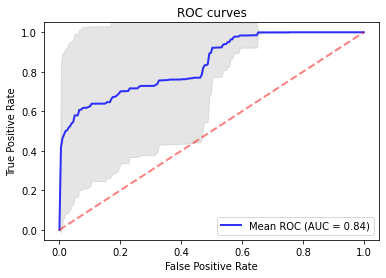

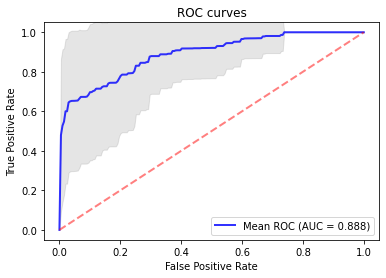

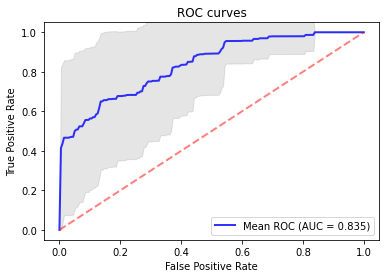

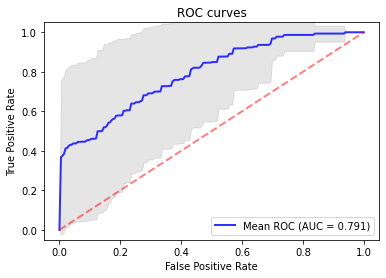

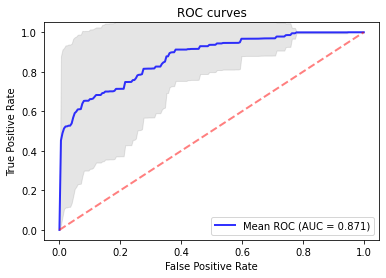

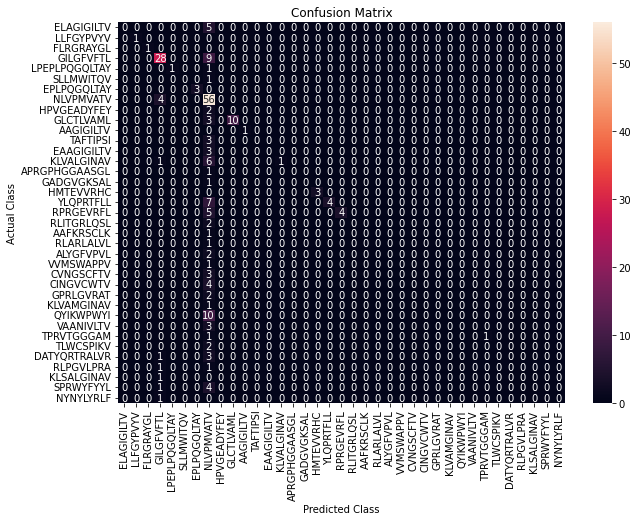

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

X, y, feature_names, kmer_count_dict, epitope_names, epitope_to_int = create_features_matrix(filtered_df, include_alpha=True, include_beta=True, alpha_col='cdr3.alpha', beta_col='cdr3.beta', label_col='antigen.epitope', k=3)
classifier = GradientBoostingClassifier(subsample=0.8,random_state=10, n_estimators=200, learning_rate=0.01, max_features='sqrt', max_depth=7)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
auc_dict3, acc_list, precision_list, recall_list, all_class_reports, all_conf_matrices, clf, misclassified_instances, misclassified_details = predict_auc(X, y, classifier, 5, epitope_names, True)


# Boxplots comparison of alpha, beta and alphabeta

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# where auc_dict 1 is alpha, aucdict2 is beta and aucdict3 is alpha+beta
def extract_average_auc(auc_dict):
    """ Extracts and calculates average AUC per fold from a given AUC dictionary. """
    return [np.mean(list(fold.values())) for fold in auc_dict.values()]


# Assuming auc_dict, auc_dict2, auc_dict3 are defined elsewhere and imported here
average_auc_alpha = extract_average_auc(auc_dict1)      # from alpha
average_auc_beta = extract_average_auc(auc_dict2)      # from beta
average_auc_alpha_beta = extract_average_auc(auc_dict3)  # from alpha+beta

# Combine the results into a list of lists for plotting
data = [average_auc_alpha, average_auc_beta, average_auc_alpha_beta]
labels = ['Alpha', 'Beta', 'Alpha+Beta']

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(data=data)
plt.xticks(ticks=range(3), labels=labels)
plt.title('Comparison of Average AUC across Different Feature Matrix Methods')
plt.xlabel('Method')
plt.ylabel('Average AUC')
plt.show()
plt.savefig('/content/alpha_vs_beta_vs_alphabeta.png')

# top and bottom performing epitopes for each method (change auc_dict to specify between methods)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extracting average AUC values
average_auc_per_fold = [np.mean(list(fold.values())) for fold in auc_dict3.values()]

# Calculating epitope-specific AUCs across folds
epitope_aucs = {epi: [] for epi in range(len(epitope_names))}  # Initialize dictionary with epitope indices
for fold in auc_dict3.values():
    for epitope, auc in fold.items():
        if isinstance(epitope, int):  # Filtering out 'micro' and 'macro'
            epitope_aucs[epitope].append(auc)

# Calculating average AUC for each epitope
average_auc_per_epitope = {epi: np.mean(aucs) for epi, aucs in epitope_aucs.items()}
sorted_epitopes = sorted(average_auc_per_epitope.items(), key=lambda item: item[1])

# Extracting top 3 and bottom 3 epitopes, converting index to names
top_3_epitopes = [(epitope_names[epi], auc) for epi, auc in sorted_epitopes[-3:]]
bottom_3_epitopes = [(epitope_names[epi], auc) for epi, auc in sorted_epitopes[:3]]

# Converting to a list for plotting using names
top_3_values = [epitope_aucs[epi] for epi, _ in sorted_epitopes[-3:]]
bottom_3_values = [epitope_aucs[epi] for epi, _ in sorted_epitopes[:3]]

# Plotting
plt.figure(figsize=(14, 6))



plt.subplot(1, 2, 1)
sns.boxplot(data=top_3_values)
plt.title('Top 3 Performing Epitopes')
plt.xticks(ticks=range(3), labels=[name for name, _ in top_3_epitopes], rotation=90)
plt.xlabel('Epitopes')
plt.ylabel('AUC')
plt.savefig('/content/alpha_beta_epitopes_topperformance.png')

plt.subplot(1, 2, 2)
sns.boxplot(data=bottom_3_values)
plt.title('Bottom 3 Performing Epitopes ')
plt.xticks(ticks=range(3), labels=[name for name, _ in bottom_3_epitopes], rotation=90)
plt.xlabel('Epitopes')
plt.ylabel('AUC')
plt.savefig('/content/apha_beta_epitopes_bottomperformance.png')

plt.tight_layout()
plt.show()

# top feature importances

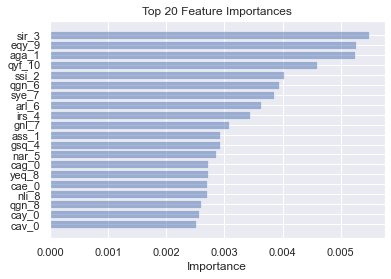

In [26]:
plot_feature_importance(clf, feature_names, top_n=20)

# positional frequencies of top importance kmers

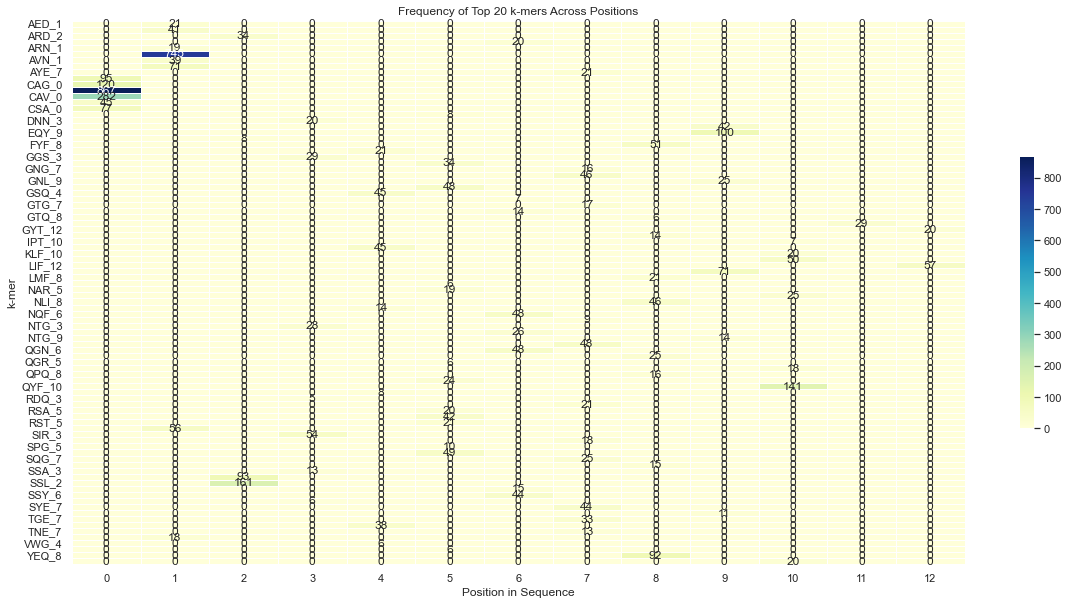

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

importances = clf.feature_importances_

    # Create a list of tuples (feature_name, importance)
feature_importance = list(zip(feature_names, importances))

    # Sort the feature importances by most important first
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

    # Taking the top n features
top_features = feature_importance[:90]
features, scores = zip(*top_features)
kmer_data = pd.DataFrame(list(kmer_count_dict.items()), columns=['kmer_pos', 'count'])
kmer_data['kmer'], kmer_data['position'] = zip(*kmer_data['kmer_pos'].apply(lambda x: (x.split('_')[0], int(x.split('_')[1]))))

# Convert `top_features` to uppercase to match the case in `kmer_data`
top_kmers_upper = [f"{feat.split('_')[0].upper()}_{feat.split('_')[1]}" for feat, importance in top_features]

# Filter `kmer_data` to include only the top k-mers
top_kmer_data = kmer_data[kmer_data['kmer_pos'].isin(top_kmers_upper)]

# Create the pivot table for the heatmap
if not top_kmer_data.empty:
    top_kmer_pivot = top_kmer_data.pivot(index='kmer_pos', columns='position', values='count').fillna(0)

    # Generate the heatmap with the top 50 k-mers
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=1)
    sns.heatmap(top_kmer_pivot, annot=True, cmap='YlGnBu', fmt=".0f", linewidths=.5, cbar_kws={'shrink': 0.5})
    plt.title('Frequency of Top 20 k-mers Across Positions')
    plt.xlabel('Position in Sequence')
    plt.ylabel('k-mer')
    plt.show()
else:
    print("No matching k-mers found in the dataset. Please check the feature names and dataset.")


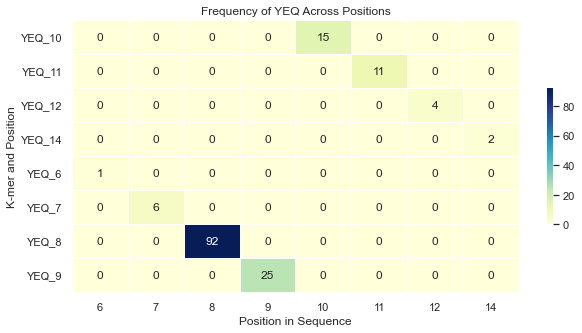

In [98]:
# Define the specific k-mer to visualize, e.g., 'ssi'
specific_kmer = 'YEQ'

# Filter for all positions of the specific k-mer
specific_kmer_data = kmer_data[kmer_data['kmer_pos'].str.contains(f'^{specific_kmer}_', case=False, regex=True)]

# Create the pivot table for the heatmap
if not specific_kmer_data.empty:
    # Extract k-mer and position
    specific_kmer_data['position'] = specific_kmer_data['kmer_pos'].apply(lambda x: int(x.split('_')[1]))
    
    # Pivot by position
    kmer_position_pivot = specific_kmer_data.pivot_table(index='kmer_pos', columns='position', values='count', aggfunc='sum').fillna(0)

    # Generate the heatmap
    plt.figure(figsize=(10, 5))
    sns.set(font_scale=1)
    sns.heatmap(kmer_position_pivot, annot=True, cmap='YlGnBu', fmt=".0f", linewidths=.5, cbar_kws={'shrink': 0.5})
    plt.title(f'Frequency of {specific_kmer} Across Positions')
    plt.xlabel('Position in Sequence')
    plt.ylabel('K-mer and Position')
    plt.show()
else:
    print("No matching positions found for the specified k-mer. Please check the feature names and dataset.")

In [39]:
import numpy as np

# Assuming 'importances' is a NumPy array of feature importances
# If it's a list, convert it first: importances = np.array(importances)

# Count the number of importances greater than zero
num_greater_than_zero = np.sum(importances > 0.000)
num_equal_to_zero = np.sum(importances == 0)
print(f"Number of features with importance greater than zero: {num_greater_than_zero}")
print(f"Number of features with importance not greater than zero: {num_equal_to_zero}")


Number of features with importance greater than zero: 6137
Number of features with importance not greater than zero: 954


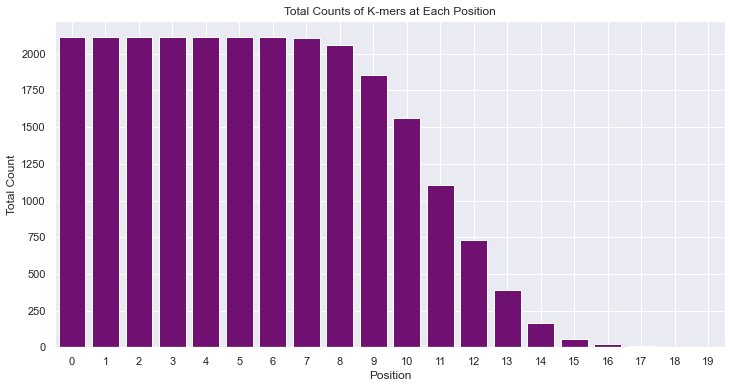

In [20]:
# Aggregate the count data by position
position_counts = kmer_data.groupby('position')['count'].sum().reset_index()

# Plotting the aggregated position counts as a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='position', y='count', data=position_counts, color='purple')
plt.title('Total Counts of K-mers at Each Position')
plt.xlabel('Position')
plt.ylabel('Total Count')
plt.grid(True)
plt.show()

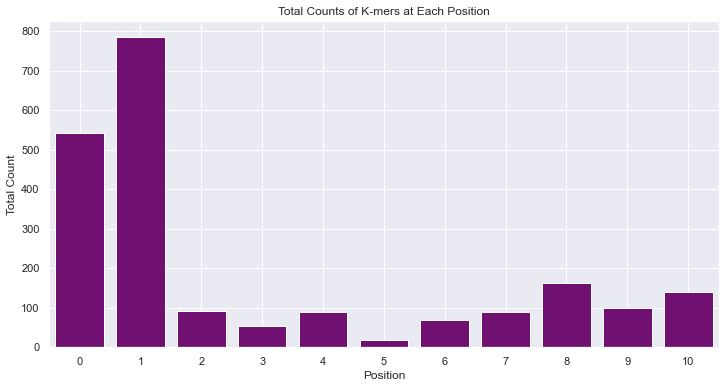

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Aggregate the count data by position
position_counts = top_kmer_data.groupby('position')['count'].sum().reset_index()

# Plotting the aggregated position counts as a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='position', y='count', data=position_counts, color='purple')
plt.title('Total Counts of K-mers at Each Position')
plt.xlabel('Position')
plt.ylabel('Total Count')
plt.grid(True)
plt.show()


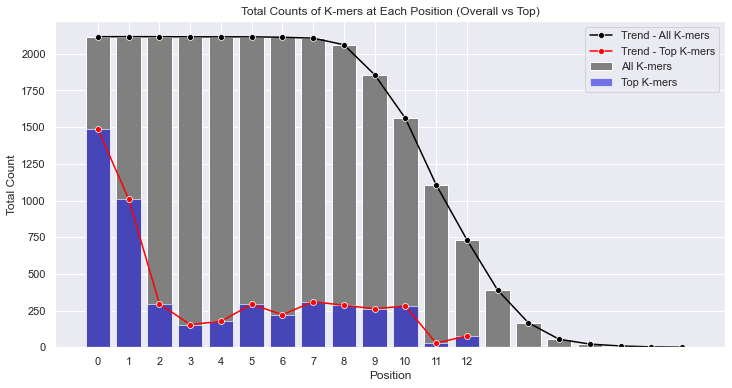

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'kmer_data' and 'top_kmer_data' are already defined
# ...

# Aggregate the count data by position for all k-mers
overall_position_counts = kmer_data.groupby('position')['count'].sum().reset_index()

# Aggregate the count data by position for top k-mers
top_position_counts = top_kmer_data.groupby('position')['count'].sum().reset_index()

# Plotting both aggregated position counts on the same bar chart
plt.figure(figsize=(12, 6))

# Plot the overall counts
sns.barplot(x='position', y='count', data=overall_position_counts, color='gray', label='All K-mers')
# Add a lineplot for the overall trend
sns.lineplot(x='position', y='count', data=overall_position_counts, color='black', marker="o", label='Trend - All K-mers')

# Plot the top counts on top
sns.barplot(x='position', y='count', data=top_position_counts, color='blue', label='Top K-mers', alpha=0.6)
# Add a lineplot for the top trend
sns.lineplot(x='position', y='count', data=top_position_counts, color='red', marker="o", label='Trend - Top K-mers')

# Additional plotting details
plt.title('Total Counts of K-mers at Each Position (Overall vs Top)')
plt.xlabel('Position')
plt.ylabel('Total Count')
plt.legend()
plt.grid(True)
plt.show()



# zoom in on specific kmer

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Define the specific k-mer to visualize, e.g., 'ssi'
specific_kmer = 'LIF'

# Filter for all positions of the specific k-mer
specific_kmer_data = kmer_data[kmer_data['kmer_pos'].str.contains(f'^{specific_kmer}_', case=False, regex=True)]

# Create the pivot table for the heatmap
if not specific_kmer_data.empty:
    # Extract k-mer and position
    specific_kmer_data['position'] = specific_kmer_data['kmer_pos'].apply(lambda x: int(x.split('_')[1]))
    
    # Pivot by position
    kmer_position_pivot = specific_kmer_data.pivot_table(index='kmer_pos', columns='position', values='count', aggfunc='sum').fillna(0)

    # Generate the heatmap
    plt.figure(figsize=(10, 5))
    sns.set(font_scale=1)
    sns.heatmap(kmer_position_pivot, annot=True, cmap='YlGnBu', fmt=".0f", linewidths=.5, cbar_kws={'shrink': 0.5})
    plt.title(f'Frequency of {specific_kmer} Across Positions')
    plt.xlabel('Position in Sequence')
    plt.ylabel('K-mer and Position')
    plt.show()
else:
    print("No matching positions found for the specified k-mer. Please check the feature names and dataset.")


# kmers in multiple positions

In [50]:
import pandas as pd



# Extract k-mer names from kmer_pos by removing the position suffix
kmer_data['kmer'] = kmer_data['kmer_pos'].apply(lambda x: x.split('_')[0])

# Group by the extracted k-mer names and count unique positions for each k-mer
kmer_position_counts = kmer_data.groupby('kmer')['kmer_pos'].nunique()

# Filter to find k-mers that appear in more than one position
kmers_in_multiple_positions = kmer_position_counts[kmer_position_counts > 1]
kmers_in_multiple_positions_sorted = kmers_in_multiple_positions.sort_values(ascending=False)
# Print the result
kmers_in_multiple_positions_sorted

kmer
LIF    13
GLT    12
AFF    12
TEA    12
QYF    12
       ..
RMN     2
RNA     2
RNQ     2
RPE     2
YYN     2
Name: kmer_pos, Length: 1514, dtype: int64

# kmers in multiple positions that are also in top importance (can specify top importance value, e.g top 20)

In [68]:
import pandas as pd

# Extract k-mer names from kmer_pos by removing the position suffix
kmer_data['kmer'] = kmer_data['kmer_pos'].apply(lambda x: x.split('_')[0])

# Group by the extracted k-mer names and count unique positions for each k-mer
kmer_position_counts = kmer_data.groupby('kmer')['kmer_pos'].nunique().head(30)

# Filter to find k-mers that appear in more than one position
kmers_in_multiple_positions = kmer_position_counts[kmer_position_counts > 1]
kmers_in_multiple_positions_sorted = kmers_in_multiple_positions.sort_values(ascending=False)
# Print the result
kmers_in_multiple_positions_sorted

kmer
ADG    9
AAG    7
AAE    4
AAS    4
AAA    3
AAF    3
AAD    2
AAL    2
AAM    2
AAN    2
AAQ    2
AAR    2
AAY    2
ADK    2
ADL    2
ADP    2
Name: kmer_pos, dtype: int64

# kmers in both top importance list and  top populousness list

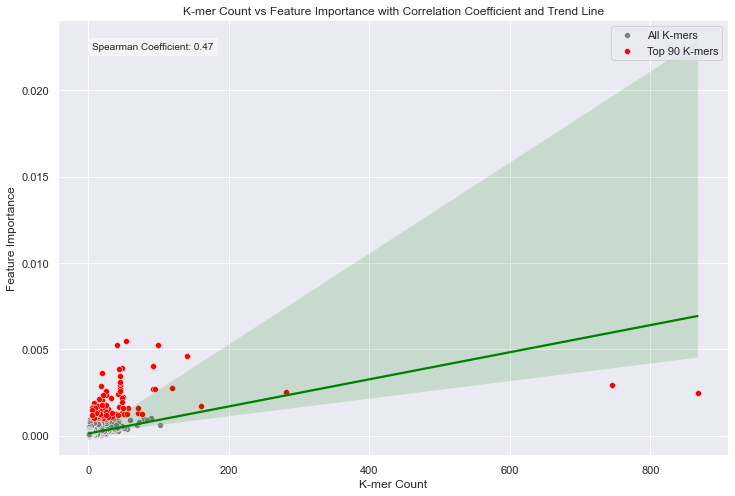

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

# Assuming 'importances', 'feature_names', and 'kmer_count_dict' have been defined and are available
# importances = clf.feature_importances_
# feature_names = [... your list of k-mer feature names ...]
# kmer_count_dict = {... your dictionary of k-mer counts ...}
# Ensure kmer_pos in feature_names are formatted exactly like those in kmer_count_dict
# Convert both to the same case to avoid case sensitivity issues
feature_names = [name.upper() for name in feature_names]  # or name.lower() if applicable
kmer_count_dict = {k.upper(): v for k, v in kmer_count_dict.items()}  # or k.lower()

# Now recreate the dataframes with the updated values
feature_importance_df = pd.DataFrame(list(zip(feature_names, importances)), columns=['kmer_pos', 'importance'])
kmer_counts_df = pd.DataFrame(list(kmer_count_dict.items()), columns=['kmer_pos', 'count'])

# Merge again
merged_data = pd.merge(kmer_counts_df, feature_importance_df, on='kmer_pos', how='left')



# Identify top 90 k-mers based on importance
top_kmers = set(feature_importance_df.nlargest(90, 'importance')['kmer_pos'])


# Plotting all k-mers
plt.figure(figsize=(12, 8))

# Scatter plot for all k-mers
sns.scatterplot(data=merged_data, x='count', y='importance', color='gray', label='All K-mers')

# Scatter plot for top 90 k-mers
sns.scatterplot(data=merged_data[merged_data['kmer_pos'].isin(top_kmers)], 
                x='count', y='importance', color='red', label='Top 90 K-mers')

# Regression line for all k-mers
sns.regplot(data=merged_data, x='count', y='importance', scatter=False, color='gray', line_kws={"color":"green"})

# Calculate correlation coefficient
spearman_coefficient, _ = spearmanr(merged_data['count'], merged_data['importance'])

# Get current axis of the plot to place the annotation relative to the plot size
ax = plt.gca()
# Add Spearman's rank correlation coefficient to the plot
plt.text(0.05, 0.95, f'Spearman Coefficient: {spearman_coefficient:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5), 
         verticalalignment='top')

# Add titles and labels
plt.title('K-mer Count vs Feature Importance with Correlation Coefficient and Trend Line')
plt.xlabel('K-mer Count')
plt.ylabel('Feature Importance')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust legend position
plt.grid(True)
plt.show()




# tying it all together

Common k-mers in both top populous and top important lists: {'CAS', 'EQY', 'NTG', 'QYF', 'ASS', 'CAV', 'YEQ'}


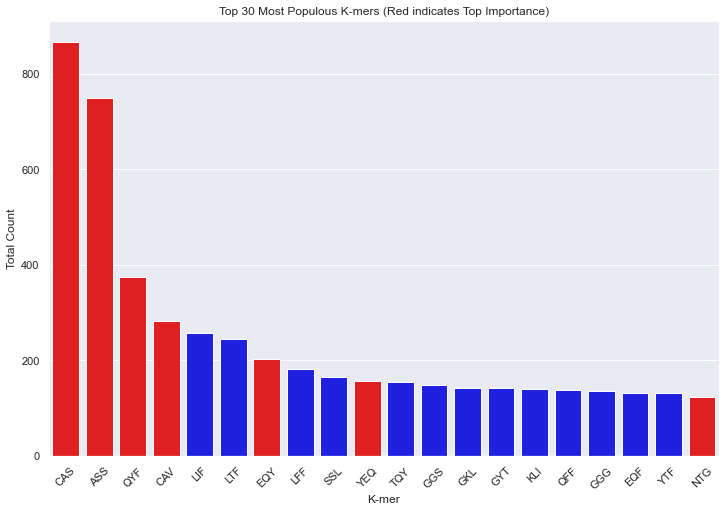

In [96]:
import pandas as pd



# Extracting k-mer name from kmer_pos and aggregating total count for each k-mer
kmer_data['kmer'] = kmer_data['kmer_pos'].apply(lambda x: x.split('_')[0])
total_counts = kmer_data.groupby('kmer')['count'].sum().reset_index()

# Convert kmer to uppercase to standardize (assuming most populous already in uppercase)
total_counts['kmer'] = total_counts['kmer'].str.upper()
most_populous_kmers = total_counts.sort_values(by='count', ascending=False).head(20)

# Assuming `clf` is your trained classifier and `feature_names` are available
importances = clf.feature_importances_  # Example feature importances, replace with actual


# Create a list of tuples (feature_name, importance) and sort by importance
feature_importance = list(zip(feature_names, importances))
feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)
top_features = feature_importance_sorted[:30]

# Convert `top_features` to uppercase k-mer names without positions for comparison
top_kmers_upper = [feat[0].split('_')[0].upper() for feat in top_features]

# Find common k-mers
common_kmers = set(most_populous_kmers['kmer']).intersection(top_kmers_upper)
print("Common k-mers in both top populous and top important lists:", common_kmers)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

# Generate the plo

## Then, the bar plot for the most populous k-mers
plt.figure(figsize=(12, 8))
sns.barplot(x='kmer', y='count', data=most_populous_kmers.head(90), 
            palette=["red" if kmer in common_kmers else "blue" for kmer in most_populous_kmers['kmer'].head(90)])
plt.xticks(rotation=45)
plt.title('Top 30 Most Populous K-mers (Red indicates Top Importance)')
plt.xlabel('K-mer')
plt.ylabel('Total Count')
plt.show()

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'clf' is your trained classifier and 'feature_names' are the k-mer positions as strings
importances = clf.feature_importances_
feature_importance = list(zip(feature_names, importances))
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
top_features = feature_importance[:90]  # Adjust according to your needs, e.g., top 90

# Keep the full k-mer position identifier for each top feature
top_kmers_with_position = [feat[0] for feat in top_features]  # No need to split here

# Extract k-mer names and count unique positions
kmer_data['kmer'] = kmer_data['kmer_pos'].apply(lambda x: x.split('_')[0].upper())
kmer_data['position'] = kmer_data['kmer_pos'].apply(lambda x: int(x.split('_')[1]))

kmer_position_counts = kmer_data.groupby('kmer')['position'].nunique().reset_index()

# Filter to get counts for k-mers that are exactly matching the top k-mers (including position)
top_kmers_position_counts = kmer_position_counts[
    kmer_position_counts['kmer'].isin([k.split('_')[0].upper() for k in top_kmers_with_position])
]

# Split into multiple positions and single position groups
top_kmers_multiple_positions = top_kmers_position_counts[top_kmers_position_counts['position'] > 1]
top_kmers_single_position = top_kmers_position_counts[top_kmers_position_counts['position'] == 1]

# Output results
print("Number of top important k-mers in multiple positions:", top_kmers_multiple_positions.shape[0])
print(top_kmers_multiple_positions)

print("Number of top important k-mers in a single position:", top_kmers_single_position.shape[0])
print(top_kmers_single_position)





Number of top important k-mers in multiple positions: 68
     kmer  position
34    AED         2
66    AGA         6
166   ARD         4
170   ARL         8
172   ARN         3
...   ...       ...
2818  VVN         2
2827  VWG         2
2863  WGT         2
2921  YEQ         8
2938  YGY        10

[68 rows x 2 columns]
Number of top important k-mers in a single position: 12
     kmer  position
226   AVN         1
229   AVR         1
264   CAE         1
266   CAG         1
276   CAS         1
278   CAV         1
280   CAY         1
300   CSA         1
1201  IRS         1
2278  SIR         1
2387  SSI         1
2429  SVW         1


# task is now to get out results from SETE and TCRdist, plus possibly langauge approach, so that we can output a combined final graph

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# AUC values for each method
auc_no_pca = np.array([0.772, 0.741, 0.768, 0.807, 0.815])
auc_pca = np.array([0.793, 0.774, 0.741, 0.751, 0.748])
auc_umap = np.array([0.639, 0.581, 0.643, 0.677, 0.65])
auc_sete = np.array([0.767,0.696,0.751,0.707])
auc_tcrdist = np.array([0.761838, 0.749288,	0.770169,	0.762701, 0.76629	])

# Calculate averages
avg_no_pca = np.mean(auc_no_pca)
avg_pca = np.mean(auc_pca)
avg_umap = np.mean(auc_umap)
avg_sete = np.mean(auc_sete)
avg_tcrdist = np.mean(auc_tcrdist)

# Calculate percentage differences
perc_diff_pca_no_pca = ((avg_pca - avg_no_pca) / avg_no_pca) * 100
perc_diff_umap_no_pca = ((avg_umap - avg_no_pca) / avg_no_pca) * 100
perc_diff_sete_no_pca = ((avg_sete - avg_no_pca) / avg_no_pca) * 100
perc_diff_tcrdist_no_pca = ((avg_tcrdist - avg_no_pca) / avg_no_pca) * 100

# Plotting
data = [auc_no_pca, auc_pca, auc_umap, auc_sete,auc_tcrdist]
fig, ax = plt.subplots()
ax.boxplot(data, labels=['No PCA', 'PCA', 'UMAP', 'SETE','TCRdist3'])
ax.set_ylabel('AUC Scores')
ax.set_title('Comparison of AUC Scores')

# Show average values on the plot
#for i, avg in enumerate([avg_no_pca, avg_pca, avg_umap], start=1):
    #ax.text(i, avg + 0.01, f'{avg:.3f}', ha='center', va='bottom', fontsize=9)

# Show the plot
plt.show()

(avg_no_pca, avg_pca, avg_umap,avg_sete,avg_tcrdist), (perc_diff_pca_no_pca, perc_diff_umap_no_pca,perc_diff_sete_no_pca,perc_diff_tcrdist_no_pca)

# also need to finish extension stuff and do epitope analysis stuff, can be found on final_outputs.py

# epitope analysis

In [102]:
misclassified_df = filtered_df.iloc[misclassified_instances]
data = misclassified_df

In [105]:
# Basic descriptive statistics for each column
data_descriptive_stats = data.describe(include='all').T

# Count of unique values for each column
data_unique_counts = data.nunique()

# Combine the statistics and unique counts
eda_results = pd.concat([data_descriptive_stats, data_unique_counts.rename('unique_values')], axis=1)

# Display the combined EDA results
eda_results


,count,unique,top,freq,mean,std,min,25%,50%,75%,max,unique_values
cdr3.alpha,513,490,CAVNSGNQFYF,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490
v.alpha,513,44,TRAV12-2*01,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44
j.alpha,478,49,TRAJ45*01,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49
cdr3.beta,513,494,CAWSETGLGMGGWQF,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,494
v.beta,513,51,TRBV19*01,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51
d.beta,96,4,TRBD1,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
j.beta,511,14,TRBJ2-7*01,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
species,513,1,HomoSapiens,513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mhc.a,513,15,HLA-A*02:01,260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
mhc.b,513,1,B2M,513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [106]:
# Calculating the lengths of sequences in specific columns
data['cdr3.alpha.length'] = data['cdr3.alpha'].str.len()
data['cdr3.beta.length'] = data['cdr3.beta'].str.len()
data['antigen.epitope.length'] = data['antigen.epitope'].str.len()  # Re-calculating to verify

# Generate summary statistics for these lengths
length_stats = data[['cdr3.alpha.length', 'cdr3.beta.length', 'antigen.epitope.length']].describe()

length_stats


,cdr3.alpha.length,cdr3.beta.length,antigen.epitope.length
count,513.000000,513.000000,513.000000
mean,13.526316,14.300195,9.403509
std,2.082242,1.838058,0.840240
min,8.000000,9.000000,8.000000
25%,12.000000,13.000000,9.000000
50%,13.000000,14.000000,9.000000
75%,15.000000,15.000000,10.000000
max,22.000000,21.000000,13.000000


# BioPython

# clustering stuff 

In [110]:
import pandas as pd
from Bio import pairwise2
import numpy as np
from Bio.Align import substitution_matrices

mouse_data = filtered_df


# Extract sequences from the dataframe
alpha_sequences = mouse_data['cdr3.alpha'].tolist()  # Adjust column name if necessary
beta_sequences = mouse_data['cdr3.beta'].tolist()  # Adjust column name if necessary

# Function to compute the similarity matrix
def compute_similarity_matrix(sequences):
    num_sequences = len(sequences)
    similarity_matrix = np.zeros((num_sequences, num_sequences))

    for i in range(num_sequences):
        for j in range(i, num_sequences):  # The matrix is symmetric
            # Perform global pairwise alignment, score_only=True to get only the alignment score
            alignments = pairwise2.align.globalxx(sequences[i], sequences[j], score_only=True)
            max_score = max(alignments) if isinstance(alignments, list) else alignments

            # Assign the max score to the corresponding place in the matrix
            similarity_matrix[i, j] = max_score
            similarity_matrix[j, i] = max_score

    return similarity_matrix

# Compute similarity matrices for both alpha and beta chains
similarity_matrix_alpha = compute_similarity_matrix(alpha_sequences)
similarity_matrix_beta = compute_similarity_matrix(beta_sequences)



In [118]:
from sklearn.manifold import TSNE
#combined_matrix = pd.DataFrame(similarity_matrix_alpha + similarity_matrix_beta)

# For alpha chain
tsne_alpha = TSNE(n_components=2, metric="precomputed", init='random')
alpha_embedded = tsne_alpha.fit_transform(1 - similarity_matrix_alpha / similarity_matrix_alpha.max())

# For beta chain
tsne_beta = TSNE(n_components=2, metric="precomputed", init='random')
beta_embedded = tsne_beta.fit_transform(1 - similarity_matrix_beta / similarity_matrix_beta.max())

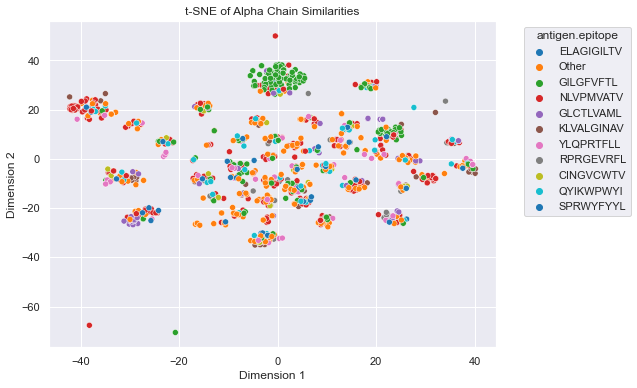

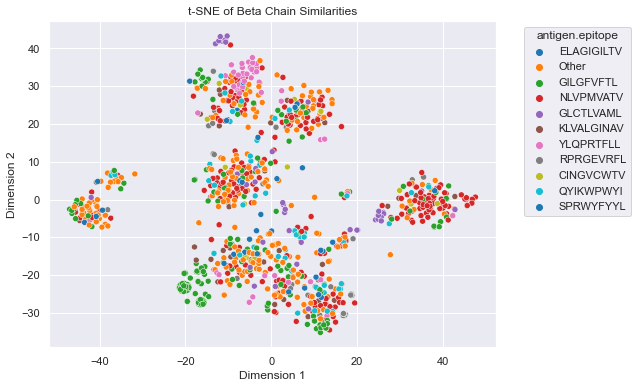

In [119]:
# Assuming df_mouse is your DataFrame and it includes an 'epitope' column
top_10_epitopes = mouse_data['antigen.epitope'].value_counts().head(10).index
# Mark sequences with their epitope if it's in the top 10, or 'Other'
mouse_data['epitope_category'] = mouse_data['antigen.epitope'].apply(lambda x: x if x in top_10_epitopes else 'Other')
import seaborn as sns

# For the alpha chain
plt.figure(figsize=(8, 6))
sns.scatterplot(x=alpha_embedded[:, 0], y=alpha_embedded[:, 1], hue=mouse_data['epitope_category'], palette='tab10', legend='full')
plt.title("t-SNE of Alpha Chain Similarities")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title='antigen.epitope', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# For the beta chain
plt.figure(figsize=(8, 6))
sns.scatterplot(x=beta_embedded[:, 0], y=beta_embedded[:, 1], hue=mouse_data['epitope_category'], palette='tab10', legend='full')
plt.title("t-SNE of Beta Chain Similarities")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title='antigen.epitope', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


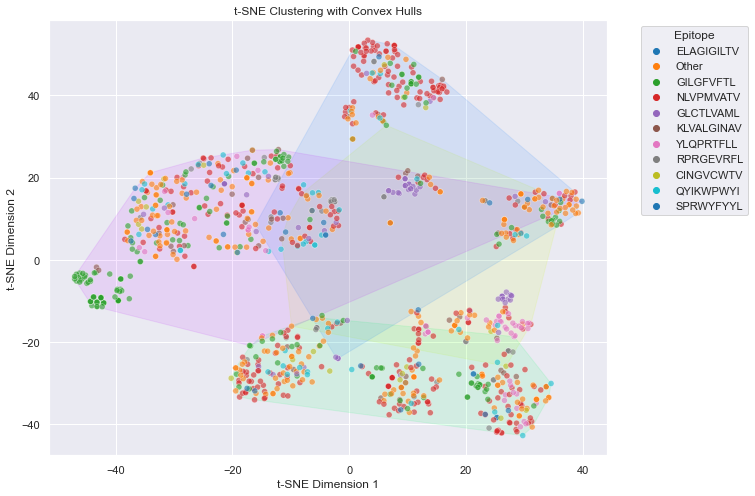

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
import seaborn as sns
import pandas as pd
# Number of clusters
k = 4  # Adjust based on your data or use methods like the elbow method to find an optimal k

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(similarity_matrix_beta)

# Get cluster labels
cluster_labels = kmeans.labels_
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(similarity_matrix_beta)
# Assuming mouse_df contains the 'epitope' data
mouse_data['tsne-2d-one'] = tsne_results[:, 0]
mouse_data['tsne-2d-two'] = tsne_results[:, 1]
mouse_data['cluster'] = cluster_labels
plt.figure(figsize=(10, 8))

# Plot each cluster using Convex Hull
palette = sns.color_palette("hsv", k)
for i in range(k):
    points = mouse_data[mouse_data['cluster'] == i][['tsne-2d-one', 'tsne-2d-two']].values
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices,0], points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1], points[hull.vertices,1][0])
    plt.fill(x_hull, y_hull, alpha=0.1, c=palette[i])

# Add points
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="epitope_category",
    palette='tab10',
    data=mouse_data,
    legend="full",
    alpha=0.6
)

plt.title('t-SNE Clustering with Convex Hulls')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Epitope', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


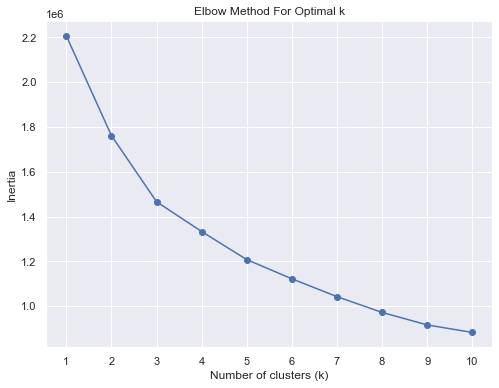

In [126]:
# Assuming combined_matrix is your data matrix
inertias = []
K_range = range(1, 11)  # Checking for 1 to 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(similarity_matrix_beta)
    inertias.append(kmeans.inertia_)
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(K_range)
plt.show()


In [129]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import numpy as np

# Define the number of clusters
k = 4  # Adjust based on your data or use methods like the elbow method to find an optimal k

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(similarity_matrix_beta)

# Get cluster labels
cluster_labels = kmeans.labels_

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(similarity_matrix_beta)

# Assuming mouse_data contains the 'epitope' data
mouse_data['tsne-2d-one'] = tsne_results[:, 0]
mouse_data['tsne-2d-two'] = tsne_results[:, 1]
mouse_data['cluster'] = cluster_labels

# Random clustering for comparison
n_clusters = 4  # Number of clusters for random assignment
mouse_data_random = mouse_data.copy()  # Make a copy to avoid modifying the original dataframe
mouse_data_random['random_cluster'] = np.random.randint(0, n_clusters, size=len(mouse_data))

# Define functions to calculate retention, purity, and consistency
def calculate_retention(df, cluster_col):
    total_sequences = len(df)
    clustered_sequences = df[df[cluster_col] != -1].shape[0]  # Assuming -1 indicates outliers or noise
    return clustered_sequences / total_sequences if total_sequences > 0 else 0

def calculate_purity(df, cluster_col, label_col):
    purity_scores = []
    for cluster in df[cluster_col].unique():
        if cluster == -1:
            continue  # Skip noise points
        cluster_df = df[df[cluster_col] == cluster]
        most_common_label = cluster_df[label_col].value_counts().idxmax()
        purity_score = cluster_df[cluster_df[label_col] == most_common_label].shape[0] / len(cluster_df)
        purity_scores.append(purity_score)
    return np.mean(purity_scores) if purity_scores else 0

def calculate_consistency(df, cluster_col, label_col):
    consistency_scores = []
    for label in df[label_col].unique():
        label_df = df[df[label_col] == label]
        if len(label_df) > 0:
            cluster_counts = label_df[cluster_col].value_counts()
            most_common_cluster = cluster_counts.idxmax()
            consistency_score = cluster_counts.max() / len(label_df)
            consistency_scores.append(consistency_score)
    return np.mean(consistency_scores) if consistency_scores else 0

# Calculate metrics for actual and random clusters
retention_actual = calculate_retention(mouse_data, 'cluster')
purity_actual = calculate_purity(mouse_data, 'cluster', 'antigen.epitope')
consistency_actual = calculate_consistency(mouse_data, 'cluster', 'antigen.epitope')

retention_random = calculate_retention(mouse_data_random, 'random_cluster')
purity_random = calculate_purity(mouse_data_random, 'random_cluster', 'antigen.epitope')
consistency_random = calculate_consistency(mouse_data_random, 'random_cluster', 'antigen.epitope')

# Print the results
print(f"Actual Clusters - Retention: {retention_actual}, Purity: {purity_actual}, Consistency: {consistency_actual}")
print(f"Random Clusters - Retention: {retention_random}, Purity: {purity_random}, Consistency: {consistency_random}")


Actual Clusters - Retention: 1.0, Purity: 0.3355557989687108, Consistency: 0.5016805302420994
Random Clusters - Retention: 1.0, Purity: 0.2840497486530864, Consistency: 0.39639070809513904


In [130]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import numpy as np

# Perform DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(similarity_matrix_beta)  # Adjust parameters as needed

# Get cluster labels (-1 indicates outliers)
cluster_labels = dbscan.labels_

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(similarity_matrix_beta)

# Assuming mouse_data contains the 'epitope' data
mouse_data['tsne-2d-one'] = tsne_results[:, 0]
mouse_data['tsne-2d-two'] = tsne_results[:, 1]
mouse_data['cluster'] = cluster_labels

# Random clustering for comparison
n_clusters = len(np.unique(cluster_labels))  # Number of clusters including outliers (-1)
mouse_data_random = mouse_data.copy()  # Make a copy to avoid modifying the original dataframe
mouse_data_random['random_cluster'] = np.random.randint(0, n_clusters, size=len(mouse_data))

# Define functions to calculate retention, purity, and consistency
def calculate_retention(df, cluster_col):
    total_sequences = len(df)
    clustered_sequences = df[df[cluster_col] != -1].shape[0]  # Assuming -1 indicates outliers or noise
    return clustered_sequences / total_sequences if total_sequences > 0 else 0

def calculate_purity(df, cluster_col, label_col):
    purity_scores = []
    for cluster in df[cluster_col].unique():
        if cluster == -1:
            continue  # Skip noise points
        cluster_df = df[df[cluster_col] == cluster]
        most_common_label = cluster_df[label_col].value_counts().idxmax()
        purity_score = cluster_df[cluster_df[label_col] == most_common_label].shape[0] / len(cluster_df)
        purity_scores.append(purity_score)
    return np.mean(purity_scores) if purity_scores else 0

def calculate_consistency(df, cluster_col, label_col):
    consistency_scores = []
    for label in df[label_col].unique():
        label_df = df[df[label_col] == label]
        if len(label_df) > 0:
            cluster_counts = label_df[cluster_col].value_counts()
            most_common_cluster = cluster_counts.idxmax()
            consistency_score = cluster_counts.max() / len(label_df)
            consistency_scores.append(consistency_score)
    return np.mean(consistency_scores) if consistency_scores else 0

# Calculate metrics for actual and random clusters
retention_actual = calculate_retention(mouse_data, 'cluster')
purity_actual = calculate_purity(mouse_data, 'cluster', 'antigen.epitope')
consistency_actual = calculate_consistency(mouse_data, 'cluster', 'antigen.epitope')

retention_random = calculate_retention(mouse_data_random, 'random_cluster')
purity_random = calculate_purity(mouse_data_random, 'random_cluster', 'antigen.epitope')
consistency_random = calculate_consistency(mouse_data_random, 'random_cluster', 'antigen.epitope')

# Print the results
print(f"Actual Clusters - Retention: {retention_actual}, Purity: {purity_actual}, Consistency: {consistency_actual}")
print(f"Random Clusters - Retention: {retention_random}, Purity: {purity_random}, Consistency: {consistency_random}")


Actual Clusters - Retention: 0.07844990548204159, Purity: 1.0, Consistency: 0.9796245256467202
Random Clusters - Retention: 1.0, Purity: 0.28328407958515783, Consistency: 0.24388942316316944


In [131]:
from sklearn.cluster import DBSCAN
import numpy as np

# Perform DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='precomputed').fit(similarity_matrix_beta)  # Adjust parameters as needed

# Get cluster labels (-1 indicates outliers)
cluster_labels = dbscan.labels_

# Assuming mouse_data contains the 'epitope' data
mouse_data['cluster'] = cluster_labels

# Random clustering for comparison
n_clusters = len(np.unique(cluster_labels))  # Number of clusters including outliers (-1)
mouse_data_random = mouse_data.copy()  # Make a copy to avoid modifying the original dataframe
mouse_data_random['random_cluster'] = np.random.randint(0, n_clusters, size=len(mouse_data))

# Define functions to calculate retention, purity, and consistency
def calculate_retention(df, cluster_col):
    total_sequences = len(df)
    clustered_sequences = df[df[cluster_col] != -1].shape[0]  # Assuming -1 indicates outliers or noise
    return clustered_sequences / total_sequences if total_sequences > 0 else 0

def calculate_purity(df, cluster_col, label_col):
    purity_scores = []
    for cluster in df[cluster_col].unique():
        if cluster == -1:
            continue  # Skip noise points
        cluster_df = df[df[cluster_col] == cluster]
        most_common_label = cluster_df[label_col].value_counts().idxmax()
        purity_score = cluster_df[cluster_df[label_col] == most_common_label].shape[0] / len(cluster_df)
        purity_scores.append(purity_score)
    return np.mean(purity_scores) if purity_scores else 0

def calculate_consistency(df, cluster_col, label_col):
    consistency_scores = []
    for label in df[label_col].unique():
        label_df = df[df[label_col] == label]
        if len(label_df) > 0:
            cluster_counts = label_df[cluster_col].value_counts()
            most_common_cluster = cluster_counts.idxmax()
            consistency_score = cluster_counts.max() / len(label_df)
            consistency_scores.append(consistency_score)
    return np.mean(consistency_scores) if consistency_scores else 0

# Calculate metrics for actual and random clusters
retention_actual = calculate_retention(mouse_data, 'cluster')
purity_actual = calculate_purity(mouse_data, 'cluster', 'antigen.epitope')
consistency_actual = calculate_consistency(mouse_data, 'cluster', 'antigen.epitope')

retention_random = calculate_retention(mouse_data_random, 'random_cluster')
purity_random = calculate_purity(mouse_data_random, 'random_cluster', 'antigen.epitope')
consistency_random = calculate_consistency(mouse_data_random, 'random_cluster', 'antigen.epitope')

# Print the results
print(f"Actual Clusters - Retention: {retention_actual}, Purity: {purity_actual}, Consistency: {consistency_actual}")
print(f"Random Clusters - Retention: {retention_random}, Purity: {purity_random}, Consistency: {consistency_random}")


Actual Clusters - Retention: 0.0, Purity: 0, Consistency: 1.0
Random Clusters - Retention: 1.0, Purity: 0.2844990548204159, Consistency: 1.0


In [132]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Assuming similarity_matrix_beta contains your similarity matrix
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(similarity_matrix_beta)

# Assuming mouse_data contains the 'epitope' data
mouse_data['tsne-2d-one'] = tsne_results[:, 0]
mouse_data['tsne-2d-two'] = tsne_results[:, 1]

# Number of clusters for K-means
k = 4  # Adjust based on your data or use methods like the elbow method to find an optimal k

# Perform K-means clustering on the t-SNE embeddings
kmeans = KMeans(n_clusters=k, random_state=0).fit(tsne_results)

# Get cluster labels
cluster_labels = kmeans.labels_

# Assign cluster labels to the dataframe
mouse_data['kmeans_cluster'] = cluster_labels
# Random clustering for comparison
n_clusters = len(np.unique(cluster_labels))  # Number of clusters including outliers (-1)
mouse_data_random = mouse_data.copy()  # Make a copy to avoid modifying the original dataframe
mouse_data_random['random_cluster'] = np.random.randint(0, n_clusters, size=len(mouse_data))

# Define functions to calculate retention, purity, and consistency
def calculate_retention(df, cluster_col):
    total_sequences = len(df)
    clustered_sequences = df[df[cluster_col] != -1].shape[0]  # Assuming -1 indicates outliers or noise
    return clustered_sequences / total_sequences if total_sequences > 0 else 0

def calculate_purity(df, cluster_col, label_col):
    purity_scores = []
    for cluster in df[cluster_col].unique():
        if cluster == -1:
            continue  # Skip noise points
        cluster_df = df[df[cluster_col] == cluster]
        most_common_label = cluster_df[label_col].value_counts().idxmax()
        purity_score = cluster_df[cluster_df[label_col] == most_common_label].shape[0] / len(cluster_df)
        purity_scores.append(purity_score)
    return np.mean(purity_scores) if purity_scores else 0

def calculate_consistency(df, cluster_col, label_col):
    consistency_scores = []
    for label in df[label_col].unique():
        label_df = df[df[label_col] == label]
        if len(label_df) > 0:
            cluster_counts = label_df[cluster_col].value_counts()
            most_common_cluster = cluster_counts.idxmax()
            consistency_score = cluster_counts.max() / len(label_df)
            consistency_scores.append(consistency_score)
    return np.mean(consistency_scores) if consistency_scores else 0

# Calculate metrics for actual and random clusters
retention_actual = calculate_retention(mouse_data, 'cluster')
purity_actual = calculate_purity(mouse_data, 'cluster', 'antigen.epitope')
consistency_actual = calculate_consistency(mouse_data, 'cluster', 'antigen.epitope')

retention_random = calculate_retention(mouse_data_random, 'random_cluster')
purity_random = calculate_purity(mouse_data_random, 'random_cluster', 'antigen.epitope')
consistency_random = calculate_consistency(mouse_data_random, 'random_cluster', 'antigen.epitope')

# Print the results
print(f"Actual Clusters - Retention: {retention_actual}, Purity: {purity_actual}, Consistency: {consistency_actual}")
print(f"Random Clusters - Retention: {retention_random}, Purity: {purity_random}, Consistency: {consistency_random}")

Actual Clusters - Retention: 0.0, Purity: 0, Consistency: 1.0
Random Clusters - Retention: 1.0, Purity: 0.2839390185786032, Consistency: 0.4091887365910379
